In [1]:
import os 

import numpy as np

from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table

import kcorrect
import kcorrect.utils as ut

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.figsize'] = [12, 12]

# Define Paths

In [3]:
filter_list = ['f105w', 'f125w', 'f140w', 'f160w']
input_catalog_formatter = "hlsp_frontier_hst_wfc3-60mas_abell2744_{}_v1.0_drz_catalog_petrosian.csv"
output_catalog_filename = "hlsp_frontier_hst_wfc3-60mas_abell2744_v1.0_drz_magnitude_catalog.csv"

# Load Catalogs

In [4]:
cat = {}

mags = {}
mag_err = {}

maggies = {}
maggies_err = {}

num_sources = None

for f in filter_list:
    cat[f] = Table.read(input_catalog_formatter.format(f))
    
    mags[f] = np.array(cat[f]['mag_total'][:]) 
    mag_err[f] = np.array(cat[f]['mag_total_err'][:])
    
    maggies[f] = ut.mag2maggies(mags[f])
    maggies_err[f] = ut.mag2maggies(mag_err[f])
    
    if num_sources is None:
        num_sources = len(cat[f])
    else:
        assert num_sources == len(cat[f])

# Load Input Filters

In [5]:
def print_filter_file(path):
    with open(path) as f:
        for line in f:
            print(line.replace("\n", ""))

In [6]:
input_filter_file = os.path.abspath('hst_filters_2.dat')

In [7]:
print_filter_file(input_filter_file)

KCORRECT_DIR
data/filters/clash_wfc3_f105w.par
data/filters/clash_wfc3_f125w.par
data/filters/clash_wfc3_f140w.par
data/filters/clash_wfc3_f160w.par


In [8]:
kcorrect.load_templates()
kcorrect.load_filters(input_filter_file)

# Fit Nonnegative Sums

In [9]:
kcorrect_constants = []

for i in range(0, num_sources):
    
    all_maggies = np.array([maggies[f][i] for f in filter_list])
    all_maggies_err = np.array([maggies_err[f][i] for f in filter_list])
    
    constants = kcorrect.fit_nonneg(0.30800, all_maggies, all_maggies_err)
    
    kcorrect_constants.append(constants)
    

# Reconstruct Maggies

In [10]:
def multi_reconstruct_maggies(kcorrect_constants, filter_list, redshift=-1.0):
    re_maggies = {f: [] for f in filter_list}
    
    for constants in kcorrect_constants:
        z, *result = kcorrect.reconstruct_maggies(constants, redshift=redshift)

        for i, f in enumerate(filter_list):
            re_maggies[f].append(result[i])
            
    for i, f in enumerate(filter_list):
        re_maggies[f] = np.array(re_maggies[f])
        
    return z, re_maggies
    

In [11]:
def stack_filter_dict(dictionary):
    return np.stack(tuple(dictionary.values()), axis=-1)

In [12]:
z, re_maggies = multi_reconstruct_maggies(kcorrect_constants, filter_list)
z0, re_maggies_z0 = multi_reconstruct_maggies(kcorrect_constants, filter_list, redshift=0)

# Compare Reconstructed Maggies Vs Input Maggies

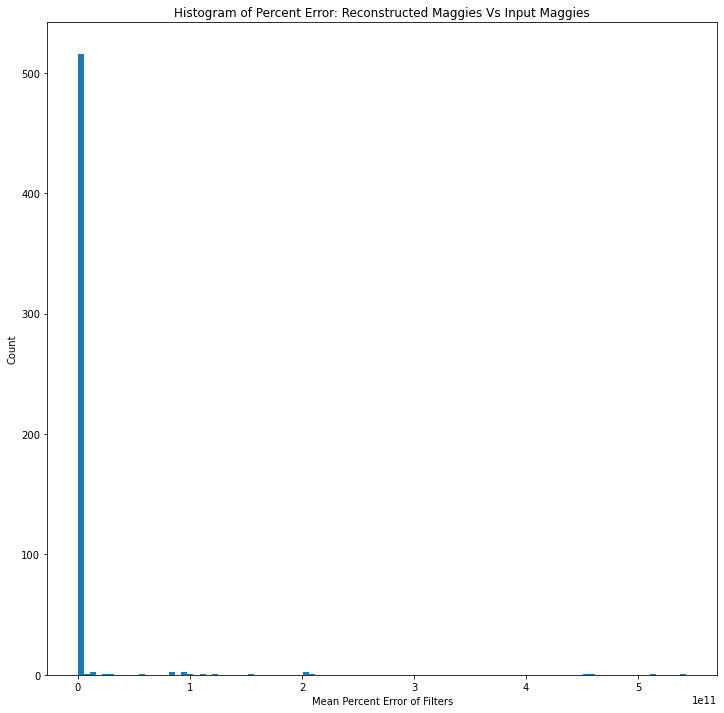

In [13]:
all_re_maggies = stack_filter_dict(re_maggies)
all_maggies = stack_filter_dict(maggies)

percent_err = 100 * (all_re_maggies - all_maggies) / all_maggies

plt.hist((percent_err).mean(axis=1), bins=100)
plt.title("Histogram of Percent Error: Reconstructed Maggies Vs Input Maggies")
plt.xlabel("Mean Percent Error of Filters")
plt.ylabel("Count")
plt.show()

# Compute kcorr

In [14]:
kcorr = -2.5 * np.log10(stack_filter_dict(re_maggies) / stack_filter_dict(re_maggies_z0))

# Load Johnson Filters

In [15]:
johnson_filter_list = ['u', 'b', 'v']

In [16]:
johnson_filter_file = os.path.abspath('johnson_b.dat')

In [17]:
print_filter_file(johnson_filter_file)

KCORRECT_DIR
data/filters/bessell_U.par
data/filters/bessell_B.par
data/filters/bessell_V.par


In [18]:
kcorrect.load_templates()
kcorrect.load_filters(johnson_filter_file)

# Compute Johnson Maggies 

In [19]:
z0, johnson_maggies_z0 = multi_reconstruct_maggies(kcorrect_constants, johnson_filter_list, redshift=0)

# Compute Vega Mag 

In [20]:
m_vega_mags = {f: [] for f in johnson_filter_list}
abs_vega_mags = {f: [] for f in johnson_filter_list}

# Johnson filters
for i, f in enumerate(johnson_filter_list):
    m_vega_mags[f] = -2.5 * np.log10(johnson_maggies_z0[f]) + 0.09
    abs_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(0.30800).value

# Original filters
for i, f in enumerate(filter_list):
    m_vega_mags[f] = -2.5 * np.log10(re_maggies_z0[f]) + 0.09
    abs_vega_mags[f] = m_vega_mags[f] - cosmo.distmod(0.30800).value


# Compute Surface Brightnesses

In [21]:
m_b = m_vega_mags['b']

In [22]:
r_half_light = np.array(cat['f105w']["r_half_light"])

In [23]:
surface_brightnesses = m_b + 5 * np.log10(r_half_light) + 2.5 * np.log10(2 * np.pi) - 10 * np.log10(1+0.30800)

<ipython-input-23-8467582b6cfe>:1: RuntimeWarning: divide by zero encountered in log10
  surface_brightnesses = m_b + 5 * np.log10(r_half_light) + 2.5 * np.log10(2 * np.pi) - 10 * np.log10(1+0.30800)


# Make Catalog

In [24]:

col_names = [
    'id',
    'sky_centroid',
    'r_petrosian',
    'r_half_light',
    'r_total_flux',
    'r_half_light_arcsec',
    'r_total_flux_arcsec',
    'r20',
    'r80',
    'c2080',
    'n_estimate',
    'f_half_light',
    'mag_half_light',
    'mag_half_light_err',
    'f_total',
    'mag_total',
    'mag_total_err',
    'surface_brightnesses',
] 


col_names += ["m_{}".format(f) for f in m_vega_mags.keys()] 
col_names += ["M_{}".format(f) for f in abs_vega_mags.keys()]
col_names += ["kcorrect_constant_{}".format(i) for i in range(len(kcorrect_constants[0]))]

final_catalog_rows = [
    cat['f105w']['id'],
    cat['f105w']['sky_centroid'],
    cat['f105w']['r_petrosian'],
    cat['f105w']['r_half_light'],
    cat['f105w']['r_total_flux'],
    cat['f105w']['r_half_light_arcsec'],
    cat['f105w']['r_total_flux_arcsec'],
    cat['f105w']['r20'],
    cat['f105w']['r80'],
    cat['f105w']['c2080'],
    cat['f105w']['n_estimate'],
    cat['f105w']['f_half_light'],
    cat['f105w']['mag_half_light'],
    cat['f105w']['mag_half_light_err'],
    cat['f105w']['f_total'],
    cat['f105w']['mag_total'],
    cat['f105w']['mag_total_err'],
    surface_brightnesses,
] 

final_catalog_rows += list(m_vega_mags.values()) 
final_catalog_rows += list(abs_vega_mags.values()) 
final_catalog_rows += list(map(list, zip(*kcorrect_constants)))    


final_catalog = Table(data=final_catalog_rows, names=col_names)

In [25]:
final_catalog

id,sky_centroid,r_petrosian,r_half_light,r_total_flux,r_half_light_arcsec,r_total_flux_arcsec,r20,r80,c2080,n_estimate,f_half_light,mag_half_light,mag_half_light_err,f_total,mag_total,mag_total_err,surface_brightnesses,m_u,m_b,m_v,m_f105w,m_f125w,m_f140w,m_f160w,M_u,M_b,M_v,M_f105w,M_f125w,M_f140w,M_f160w,kcorrect_constant_0,kcorrect_constant_1,kcorrect_constant_2,kcorrect_constant_3,kcorrect_constant_4,kcorrect_constant_5
int64,str38,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
273,"3.5919245269315696,-30.405767771267364",126.95479095819164,--,253.90958191638327,--,15.234572090586028,--,--,--,--,--,--,--,--,--,--,-inf,0.47022906,0.30040002,0.3502972,0.3830478,0.41101798,0.414316,0.41220567,-40.57893,-40.74876,-40.698864,-40.66611,-40.63814,-40.634846,-40.636955,0.308,8.829624,0.2320289,1.1005545,1.5946923,9.856587
339,"3.5862748381452128,-30.400429314663135",84.07261452290459,36.271054210842166,168.14522904580917,2.1762628491846394,10.088711872362756,11.21004200840168,76.69353870774155,4.175757684473675,3.082253002812057,2556.10682865093,17.74987036709313,22.00934411778329,5111.359896760352,16.997476715452272,21.633147291962857,26.336695370552277,17.87267,17.709522,17.680086,16.986286,16.800528,16.696545,16.586615,-23.17649,-23.339638,-23.369074,-24.062874,-24.248632,-24.352615,-24.462545,0.308,7.2189e-06,2.8921207e-08,4.1031302e-07,8.372497e-07,5.051484e-07
455,"3.594814218595431,-30.3916651495097",62.538707741548315,23.18363672734547,125.07741548309663,1.391017945754465,7.50464353767055,8.100620124024806,55.43808761752351,4.176449869834916,3.0839668781803424,1428.5754475137028,18.381559914055593,22.325188891264517,2856.327348335467,17.629297923187693,21.94905789583057,25.912190370437582,18.402716,18.25691,18.254223,17.650288,17.479452,17.381239,17.276508,-22.646444,-22.79225,-22.794937,-23.398872,-23.569708,-23.667921,-23.772652,0.308,3.7351895e-06,1.7962325e-08,2.2870336e-07,4.489837e-07,3.005113e-07
379,"3.5854180928586743,-30.39421281208224",46.89877975595119,17.66093218643729,93.79755951190238,1.0596557347325117,5.627852527344528,5.826565313062613,46.43468693738748,4.507149514131746,4.023005713560103,1018.6908662706542,18.748711837901453,22.50876485318745,2037.8271204484895,17.995899524081413,22.13235869627743,25.715401268018194,18.802862,18.65096,18.639694,18.0072,17.831194,17.731047,17.624617,-22.246298,-22.3982,-22.409466,-23.04196,-23.217966,-23.318113,-23.424543,0.308,2.7397768e-06,1.23350175e-08,1.5685151e-07,2.9718387e-07,2.1788377e-07
283,"3.59261551144839,-30.404485926812793",41.654530906181236,18.125025005001,83.30906181236247,1.0875012986839363,4.998542782042331,5.501700340068014,41.97939587917584,4.4126962616710985,3.729149464695322,942.1054549133827,18.83356907241577,22.55119347044461,1885.3579584874974,18.080333322122904,22.174575595298172,25.840919111553145,18.870487,18.720154,18.712963,18.099756,17.927406,17.82877,17.72371,-22.178673,-22.329006,-22.336197,-22.949404,-23.121754,-23.22039,-23.32545,0.308,2.482651e-06,1.1583193e-08,1.451385e-07,2.7426654e-07,2.0712898e-07
366,"3.587595012409505,-30.396447326611995",50.936387277455495,18.728345669133827,101.87277455491099,1.1237005318207884,6.112365340099317,5.73374674934987,45.460092018403685,4.495959017730987,3.9870531729443686,985.8334438115623,18.78430900034876,22.526563434411102,1973.4306527171434,18.03076319425601,22.149790531364726,25.880097920876214,18.832043,18.688229,18.679647,18.028408,17.847977,17.745564,17.636986,-22.217117,-22.360931,-22.369513,-23.020752,-23.201183,-23.303596,-23.412174,0.308,2.7352469e-06,1.2243767e-08,1.6243106e-07,3.2716702e-07,1.8009031e-07
56,"3.5696516943216072,-30.40507042141748",4.944788957791559,2.0674134826965394,9.889577915583118,0.12404478596464381,0.5933745649269532,1.0928185

# Save Catalog

In [27]:
final_catalog.write(output_catalog_filename, format="ascii.csv", overwrite=True)